In [1]:
import os

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from tqdm import tqdm, trange
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

from helpers import projs, get_data, apwnorm

### Load cubes:

In [2]:
# cube, dm, footprint_mask = get_data(bass_file='../data/bass_dr8_iso_hpxcube_v6.fits.gz', 
#                                     decals_file='../data/decals_dr8_iso_hpxcube_v6.fits.gz',
#                                     bass_scale_factor=1.25)

cube, dm, footprint_mask = get_data(bass_file='../data/bass_dr8_iso_hpxcube_v0.fits.gz', 
                                    decals_file='../data/decals_dr8_iso_hpxcube_v4.fits.gz',
                                    bass_scale_factor=1.3)

npix, nslice = cube.shape
nside = hp.npix2nside(npix)

In [72]:
pix_idx = np.arange(hp.nside2npix(nside), dtype=int)
pix_c = hp.pix2ang(nside, pix_idx, 
                   lonlat=True)
pix_c = coord.SkyCoord(pix_c[0]*u.deg, pix_c[1]*u.deg)

In [73]:
pix_gal = pix_c.transform_to(coord.Galactic)
pix_l = pix_gal.l
pix_b = pix_gal.b

In [74]:
pix_b_mask = (((np.abs(pix_b) > 20*u.deg) 
               & (np.abs(pix_l - 180*u.deg) < 90*u.deg)) 
              | ((np.abs(pix_b) > 40*u.deg) & (np.abs(pix_l) < 90*u.deg)))

Stitch together the cubes in a better way:

In [75]:
# from scipy.optimize import leastsq

# def test(p, x1, x2):
#     _mask = np.isfinite(x1) & np.isfinite(x2)
#     return x1[_mask] - (x2[_mask] + p[0])

# tmp_cube1 = cube1.copy()
# tmp_cube2 = cube2.copy()

# offsets = []
# iers = []
# for i in range(n_slice):
#     _mask = (tmp_cube1[:, i] != 0) & (tmp_cube2[:, i] != 0)
#     res, ier = leastsq(test, x0=[0.], args=(np.log(tmp_cube1[_mask, i]), 
#                                             np.log(tmp_cube2[_mask, i])))
#     offsets.append(res[0])
#     iers.append(ier)
#     tmp_cube2[_mask, i] = np.exp(np.log(tmp_cube2[_mask, i]) + res[0])

In [76]:
# plt.figure(figsize=(6, 6))

# i = 10
# _mask = (tmp_cube1[:, i] != 0) & (tmp_cube2[:, i] != 0)
# plt.plot(tmp_cube1[_mask, i], tmp_cube2[_mask, i], 
#          marker='o', ls='none', mew=0, alpha=0.2, ms=2.5)
# plt.plot(np.linspace(0, 50, 10), 
#          np.linspace(0, 50, 10),
#          marker='')
# plt.xlim(0, 50)
# plt.ylim(0, 50)

In [77]:
# def ramp_func(dec, k=0.8):
#     x0 = 35.4
#     return 1 / (1 + np.exp(-k*(dec-x0)))

In [78]:
# cube = np.zeros_like(cube1)
# for i in trange(n_slice):
#     _mask = (tmp_cube1[:, i] != 0) & (tmp_cube2[:, i] != 0)
#     cube[~_mask, i] += cube1[~_mask, i]
#     cube[~_mask, i] += cube2[~_mask, i]
#     cube[_mask, i] = (cube1[_mask, i] * ramp_func(pix_ang[1][_mask], 0.4) + 
#                       cube2[_mask, i] * (1-ramp_func(pix_ang[1][_mask], 0.4)))

In [79]:
# tmp_cube2 = cube2.copy() * 1.5
# tmp_cube2[cube1 != 0] = 0.

# cube = cube1 + tmp_cube2
cubesum = np.sum(cube, axis=1)
footprint_mask = cubesum != 0

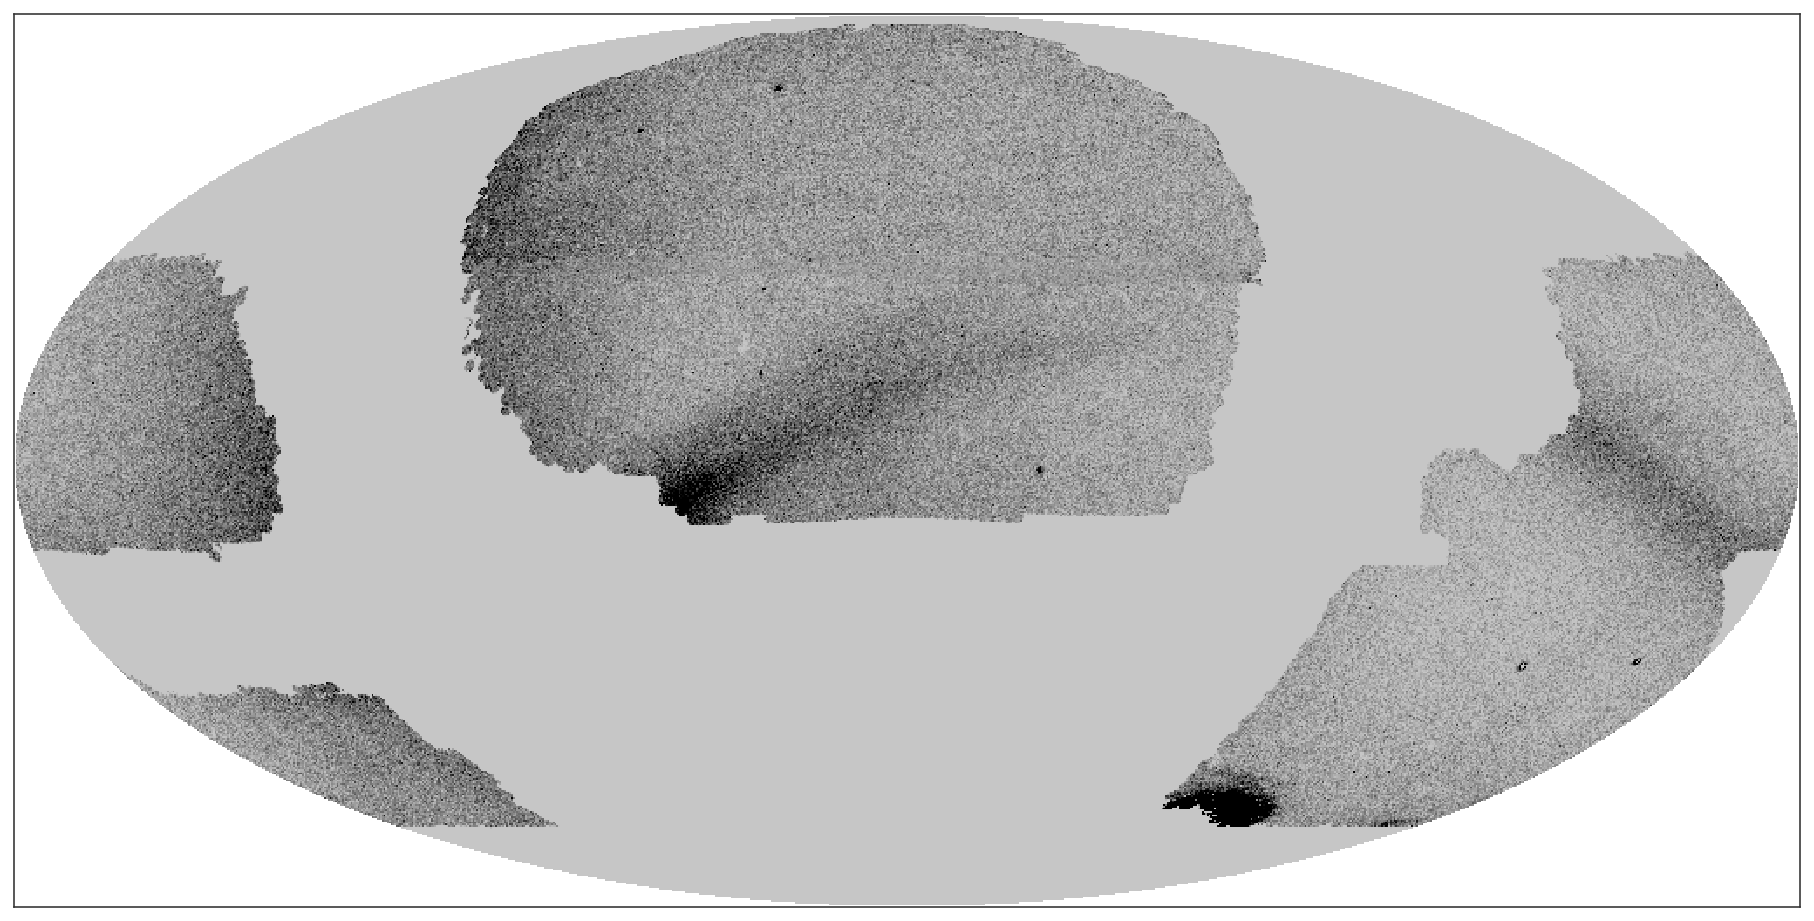

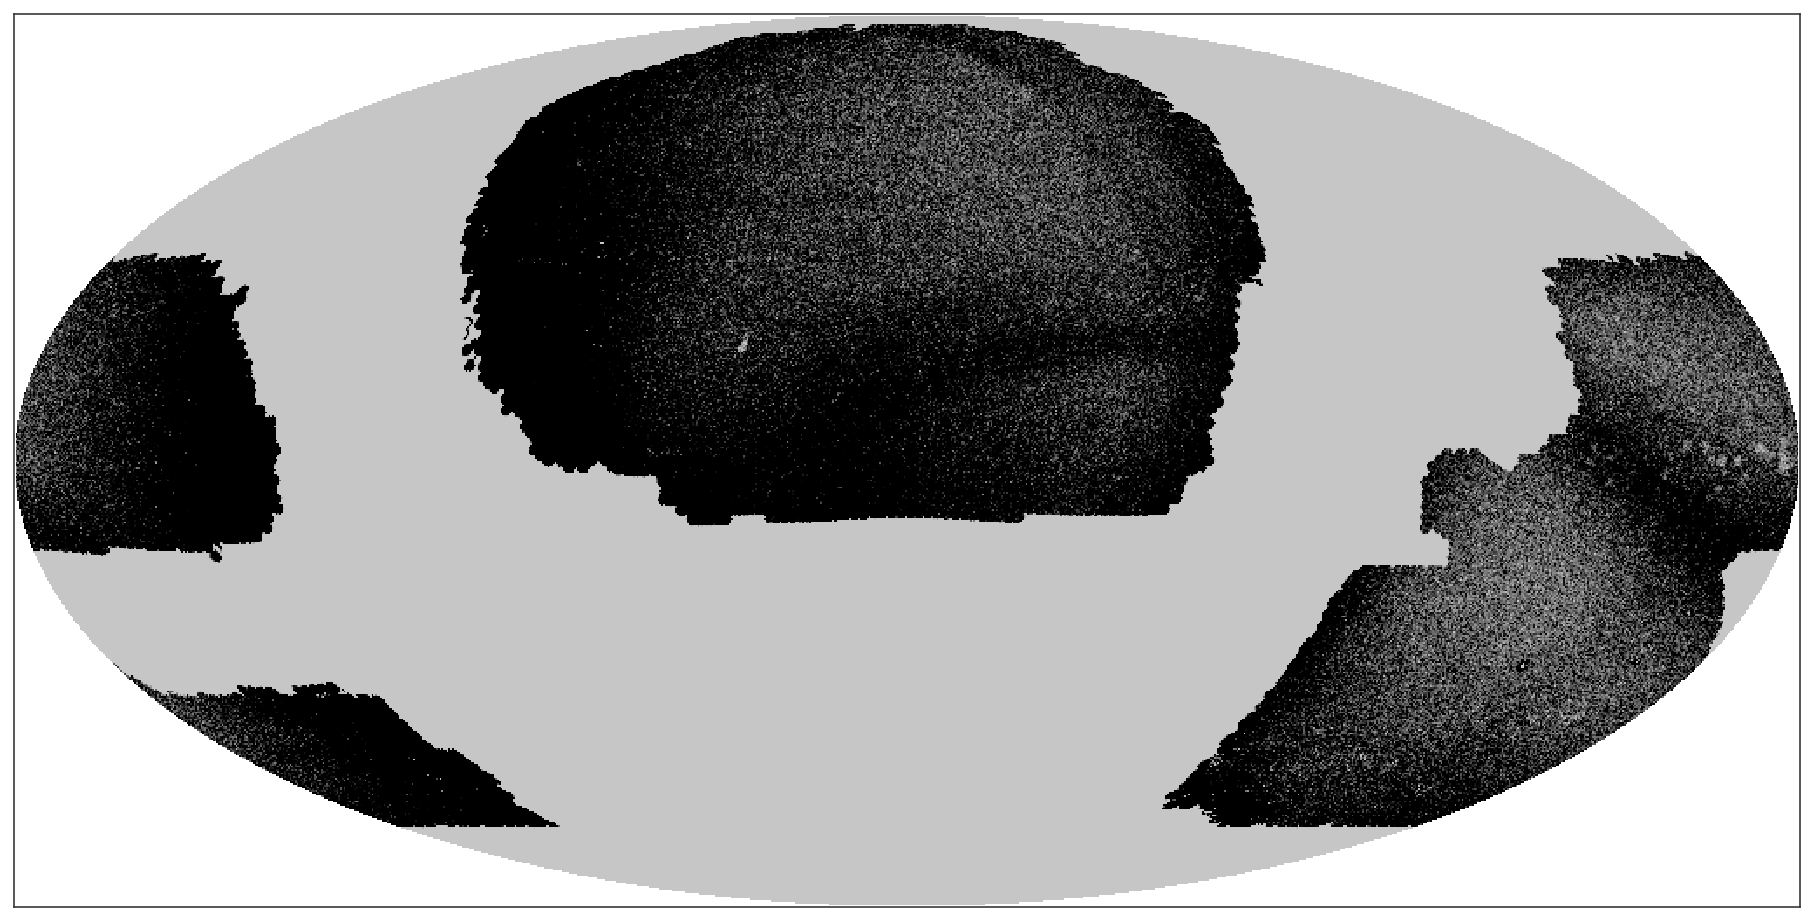

In [80]:
proj = hp.projector.MollweideProj(xsize=1024, 
                                  rot=[266.40498829, -28.93617776, 59.])

img = projs['icrs'].projmap(np.sum(cube[:, 50:], axis=1)/10, func)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-5, vmax=1e1, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

img = projs['icrs'].projmap(np.sum(cube[:, 10:25], axis=1)/10, func)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-5, vmax=1e1, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

---

### Known globs and blobs

In [81]:
all_blobs = at.Table.read('/Users/apricewhelan/data/Misc/MW_dwarfs_globs.fits')
all_blobs = all_blobs[all_blobs['DM'] < 25]
all_blobs_c = coord.SkyCoord(all_blobs['ra']*u.deg,
                             all_blobs['dec']*u.deg,
                             coord.Distance(distmod=all_blobs['DM']))

# Special case some half-light radii:
all_blobs['r_h'][all_blobs['name'] == 'SagittariusdSph'] = 2.5 * 60
all_blobs['r_h'][all_blobs['name'] == '#Andromeda'] = 1.5 * 60
all_blobs['r_h'][all_blobs['name'] == 'BootesIII'] = 10
all_blobs['r_h'][all_blobs['name'] == 'LMC'] = 5*60
all_blobs['r_h'][all_blobs['name'] == 'SMC'] = 2.5*60
all_blobs['r_h'][all_blobs['name'] == 'Triangulum'] = 60
all_blobs['r_h'][all_blobs['name'] == 'NGC5904 (M 5)'] /= 2

blobs = at.Table.read('/Users/apricewhelan/data/Misc/Vasiliev-globclust.txt',
                      format='ascii.basic')
blobs.rename_column('Name', 'name')
blobs_c = coord.SkyCoord(blobs['RA']*u.deg,
                         blobs['DEC']*u.deg,
                         blobs['D']*u.kpc)

In [82]:
in_footprint_idx = []
for i, cl_c in enumerate(blobs_c):
    pix = hp.ang2pix(nside, cl_c.ra.degree, cl_c.dec.degree, 
                     lonlat=True)
    
    if footprint_mask[pix]:
        in_footprint_idx.append(True)
    else:
        in_footprint_idx.append(False)
        
in_footprint_idx = np.array(in_footprint_idx)

In [83]:
len(blobs[in_footprint_idx])

26

In [84]:
blobs[in_footprint_idx]

<Table length=26>
 col0       name         RA     DEC      D    ...  corrPM  radius Nmember col14
int64      str21      float64 float64 float64 ... float64 float64  int64  int64
----- --------------- ------- ------- ------- ... ------- ------- ------- -----
   --         NGC 288  13.188 -26.583     8.9 ...   0.198     8.0    6166    --
   --       Whiting 1  30.738  -3.253    30.1 ...  -0.073     3.0      39    --
   --        NGC 1261  48.068 -55.216    16.3 ...   0.152     6.0    1865    --
   --      E 1 (AM 1)   58.76 -49.615   123.3 ...   -0.13     2.5      37    --
   --        Eridanus  66.185 -21.187    90.1 ...  -0.317     4.0      31    --
   --        NGC 1851  78.528 -40.047    12.1 ...  -0.101    10.0    4639    --
   -- NGC 1904 (M 79)  81.046 -24.525    12.9 ...  -0.033     8.0    2747    --
   --        NGC 2419 114.535  38.882    82.6 ...   0.108     5.0     826    --
   --           Pal 3 151.383   0.072    92.5 ...   -0.51     3.0      36    --
   --           Pal 4  172.32  28.974   108.7 ...  -0.646     4.0      30    --
  ...             ...     ...     ...     ... ...     ...     ...     ...   ...
   --           Pal 5 229.022  -0.112    23.2 ...   -0.39     6.0     242    --
   --  NGC 5904 (M 5) 229.638   2.081     7.5 ...  -0.037    20.0   14254    --
   --  Pal 14 (Arp 1) 242.752  14.958    76.5 ...   0.437     5.0      80    --
   -- NGC 6205 (M 13) 250.422   36.46     7.1 ...   0.152    15.0   16325    --
   --        NGC 6229 251.745  47.528    30.5 ...   0.131     4.0     418    --
   -- NGC 6981 (M 72) 313.365 -12.537    17.0 ...   0.294     4.0    1242    --
   --        NGC 7006 315.372  16.187    41.2 ...  -0.091     3.0     297    --
   -- NGC 7078 (M 15) 322.493  12.167    10.4 ...  -0.037    10.0    7403    --
   --  NGC 7089 (M 2) 323.363  -0.823    11.5 ...   0.027     8.0    4272    --
   --          Pal 13 346.685  12.772    26.0 ...   0.026     3.0      56    --

### Come up with a mask for bright galaxies and globular clusters

In [85]:
this_blob_mask = np.ones(hp.nside2npix(nside))
for row, cc in zip(all_blobs, all_blobs_c):        
    size = (cc.distance * row['r_h']*u.arcmin).to_value(u.kpc, u.dimensionless_angles())
    rep = coord.CartesianRepresentation(np.random.normal(cc.cartesian.xyz.to_value(u.kpc), 
                                                         2 * size, 
                                                         (65536, 3)).T * u.kpc)
    spray = coord.SkyCoord(rep)
    this_blob_mask[hp.ang2pix(nside, spray.ra.degree, spray.dec.degree, lonlat=True)] = 0.
    
# Also mask out Sag:
# mask_c = gc.Sagittarius(np.random.uniform(0, 360, 4*65536)*u.deg,
#                         np.random.normal(0, 10, 4*65536)*u.deg).transform_to(coord.ICRS)
# this_blob_mask[hp.ang2pix(nside, mask_c.ra.degree, mask_c.dec.degree, lonlat=True)] = 0.
    
this_blob_mask = hp.smoothing(this_blob_mask, sigma=np.radians(0.2))
_derp = this_blob_mask > 0.8
this_blob_mask[_derp] = 1
this_blob_mask[~_derp] = 0
blob_mask = np.array(1 - this_blob_mask, dtype=bool)

full_stack = np.sum(cube, axis=1) / nslice
full_stack_masked = full_stack * this_blob_mask
full_stack_masked[full_stack_masked > 1e3] = 0.

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### huh

In [86]:
# Xnoblob = np.percentile(cube, 15, axis=1).copy()
# Xnoblob[blob_mask] = 0.
# Xnoblob = hp.smoothing(Xnoblob, sigma=np.radians(5))
# img = projs['icrs'].projmap(Xnoblob, func) 

# fig, ax = plt.subplots(1, 1, figsize=(16, 16))
# ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
#           cmap='Greys', vmax=1e1)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)

### Images in different projections

In [103]:
# slices = [(35, 60),
#           (20, 35),
#           (6, 20)]

# slices = [(40, 60),
#           (30, 40),
#           (19, 30)]

# slices = [(25, 50),
#           (12, 25),
#           (5, 12)]

# ORPHAN HACK:
slices = [(35, 55),
          (25, 35),
          (15, 25)]

slice_str = '_'.join(['{}-{}'.format(x,y) for x,y in slices])
dist = coord.Distance(distmod=dm)

for x, y in slices:
    print(dist[x], dist[y])

31.6227766016836 kpc 79.43282347242742 kpc
19.952623149688748 kpc 31.6227766016836 kpc
12.589254117941637 kpc 19.952623149688748 kpc


In [117]:
stacks = np.stack([np.sum(cube[:, x:y], axis=1) / (y - x) 
                   for x, y in slices], 
                  axis=-1)

rgb = np.zeros_like(stacks)
for i in range(3):
    X = stacks[..., i]

    # No bg subtrack:
    rgb[..., i] = hp.smoothing(X, sigma=np.radians(0.2))
#     rgb[..., i] = X
    
    # Subtract smoothed
#     Xnoblob = X.copy()
#     Xnoblob[blob_mask] = 0.
#     rgb[..., i] = (hp.smoothing(X, sigma=np.radians(0.15)) - 
#                    hp.smoothing(Xnoblob, sigma=np.radians(7.5)))
    
    # Subtract crazy-ass background model from above
    # rgb[..., i] = X - bg_model
    # rgb[..., i] = X - get_bg(X)
    # rgb[..., i] = hp.smoothing(rgb[..., i], sigma=np.radians(0.2))
    
    rgb[X==0, i] = 0.

for i in range(3):
    X = stacks[..., i]
    
    _mask = (rgb[..., i] != 0) & pix_b_mask
    rgb[..., i] = apwnorm(rgb[..., i], 
                          min=np.percentile(rgb[..., i][_mask], 1.5), # 1 
                          max=np.percentile(rgb[..., i][_mask], 99)) # 99
    # a = 1e-1
    # rgb[..., i] = np.arcsinh(rgb[..., i]/a) / np.arcsinh(1/a)
    
    rgb[X==0, i] = 0.

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Plot each channel separately, first:

In [118]:
# proj = projs['icrs-ortho']

# for i in range(2, 0-1, -1):    
#     fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#     fig.tight_layout()
    
#     X = rgb[:, i]
#     # X = rgb[:, i].copy()
#     # X[~pix_b_mask] = 0.
    
#     im = ax.imshow(proj.projmap(X, func), 
#                    cmap='Greys', origin='bottom', extent=proj.get_extent())
#     vmin = np.percentile(X, 1),
#     vmax = np.percentile(X, 99)
#     im.norm.vmin = vmin
#     im.norm.vmax = vmax
    
#     # break

In [119]:
projs['pal5'] = hp.projector.MollweideProj(xsize=1024, 
                                           rot=get_rot(gc.Pal5()))

In [120]:
label = False

for name, proj in projs.items():
    if name != 'sag': continue
        
    img = np.stack([proj.projmap(rgb[:, i], func) 
                    for i in range(3)], axis=-1)
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.imshow(img, origin='bottom', extent=proj.get_extent())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.set_title('r{}  g{}  b{}'.format(*['{:.1f}–{:.1f}'.format(dm[x], dm[y]) 
                                          for x, y in slices]))

    fig.tight_layout()
    fig.savefig(f'../plots/fieldofstreams/gr/fos_{name}_{slice_str}.png', dpi=300)

    if label:
        for k, (row2, c2) in enumerate(zip(all_blobs, all_blobs_c)):
            if np.sum(rgb, axis=-1)[hp.ang2pix(nside, c2.ra.degree, c2.dec.degree, lonlat=True)] == 0:
                continue
            
            if 'andromeda' in row2['name'].lower():
                continue

            xy = proj.ang2xy(c2.ra.degree, c2.dec.degree, lonlat=True)

            color = 'tab:red'
            hack_radius = row2['r_h']/600
            ax.add_patch(mpl.patches.Circle(xy, radius=hack_radius,
                                            facecolor='none', 
                                            edgecolor=color, zorder=100, 
                                            linewidth=1))
            ax.text(xy[0], xy[1] + hack_radius, row2['name'], 
                    color=color, zorder=200,
                    fontsize=10, ha='center', va='bottom')
        # fig.savefig(f'../plots/fieldofstreams/fos_{name}_{slice_str}_labeled.png', dpi=300)
        
    plt.close(fig)

### Animations

In [23]:
from matplotlib.animation import FuncAnimation

In [24]:
distances = coord.Distance(distmod=dm).to_value(u.kpc)

0
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
1
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
2
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
3
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
4
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
5
Sigma is 9.000000 arcmin 

57
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
58
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
59
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
60
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
61
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0
Sigma is 9.000000 ar

52
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
53
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
54
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
55
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
56
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
57
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
58
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
59
Sigma is 9.000000

47
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
48
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
49
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
50
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
51
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
52
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
53
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
54
Sigma is 9.000000

42
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
43
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
44
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
45
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
46
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
47
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
48
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
49
Sigma is 9.000000

37
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
38
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
39
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
40
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
41
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
42
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
43
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
44
Sigma is 9.000000

32
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
33
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
34
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
35
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
36
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
37
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
38
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
39
Sigma is 9.000000

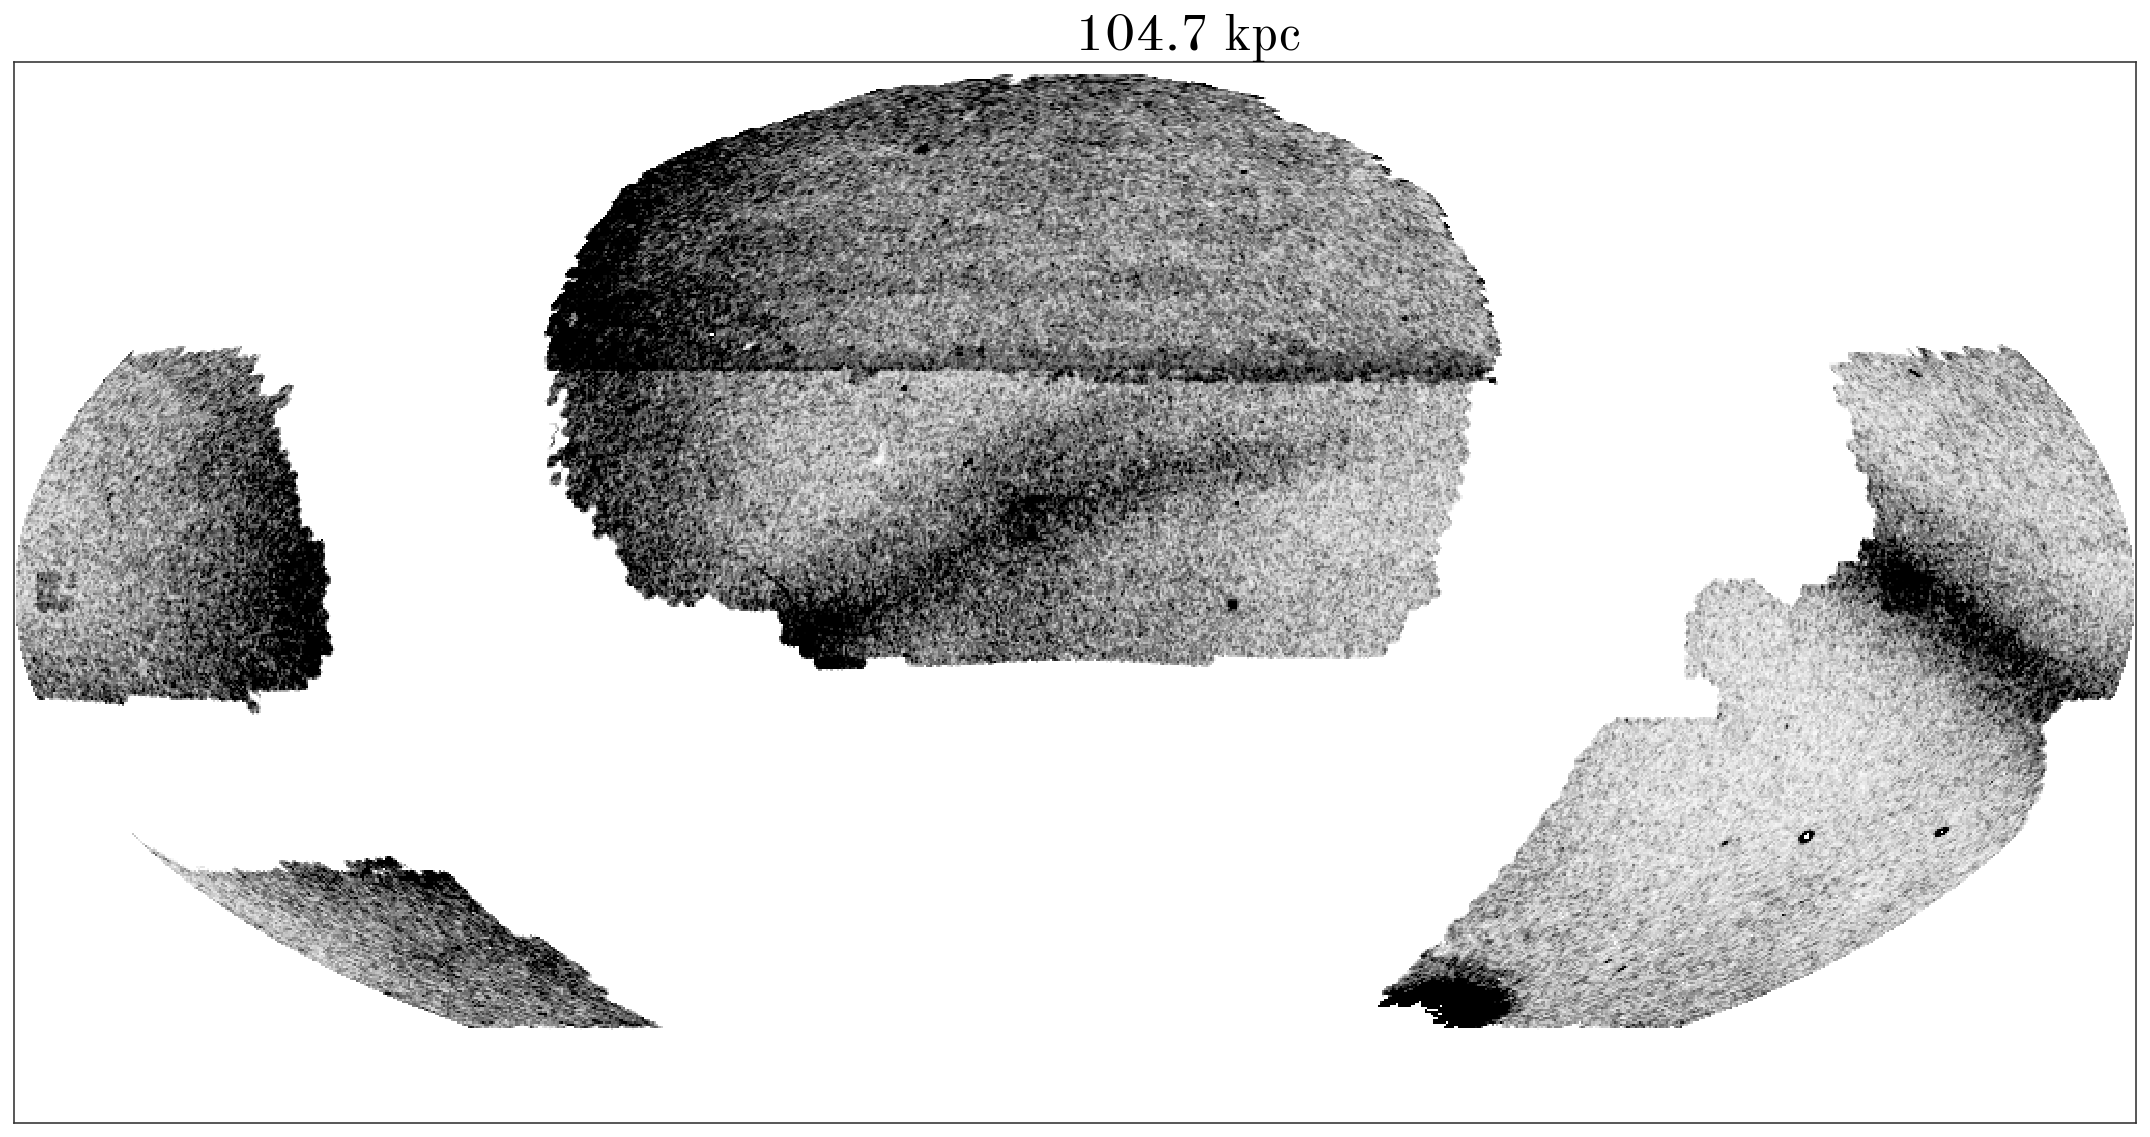

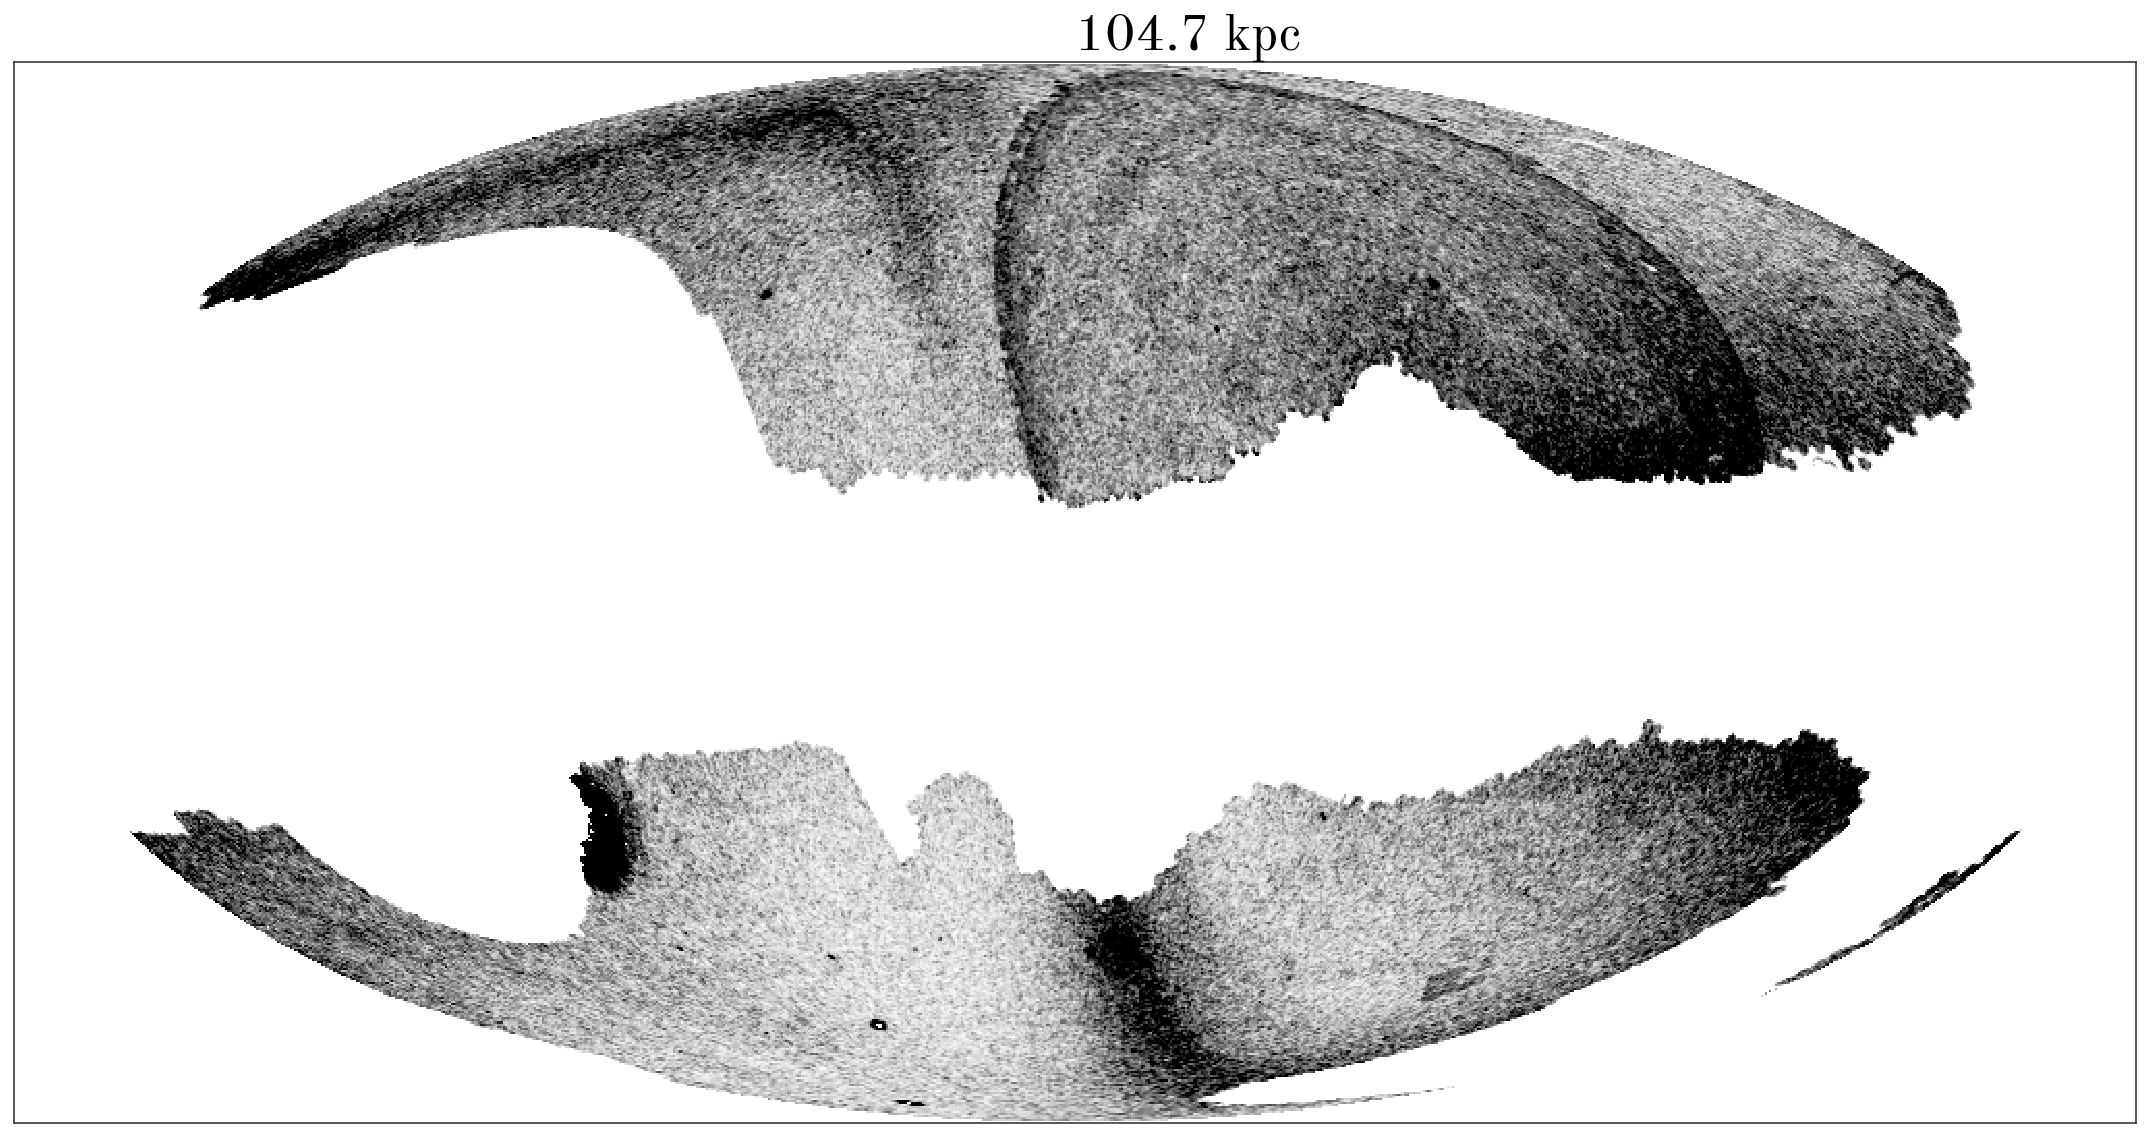

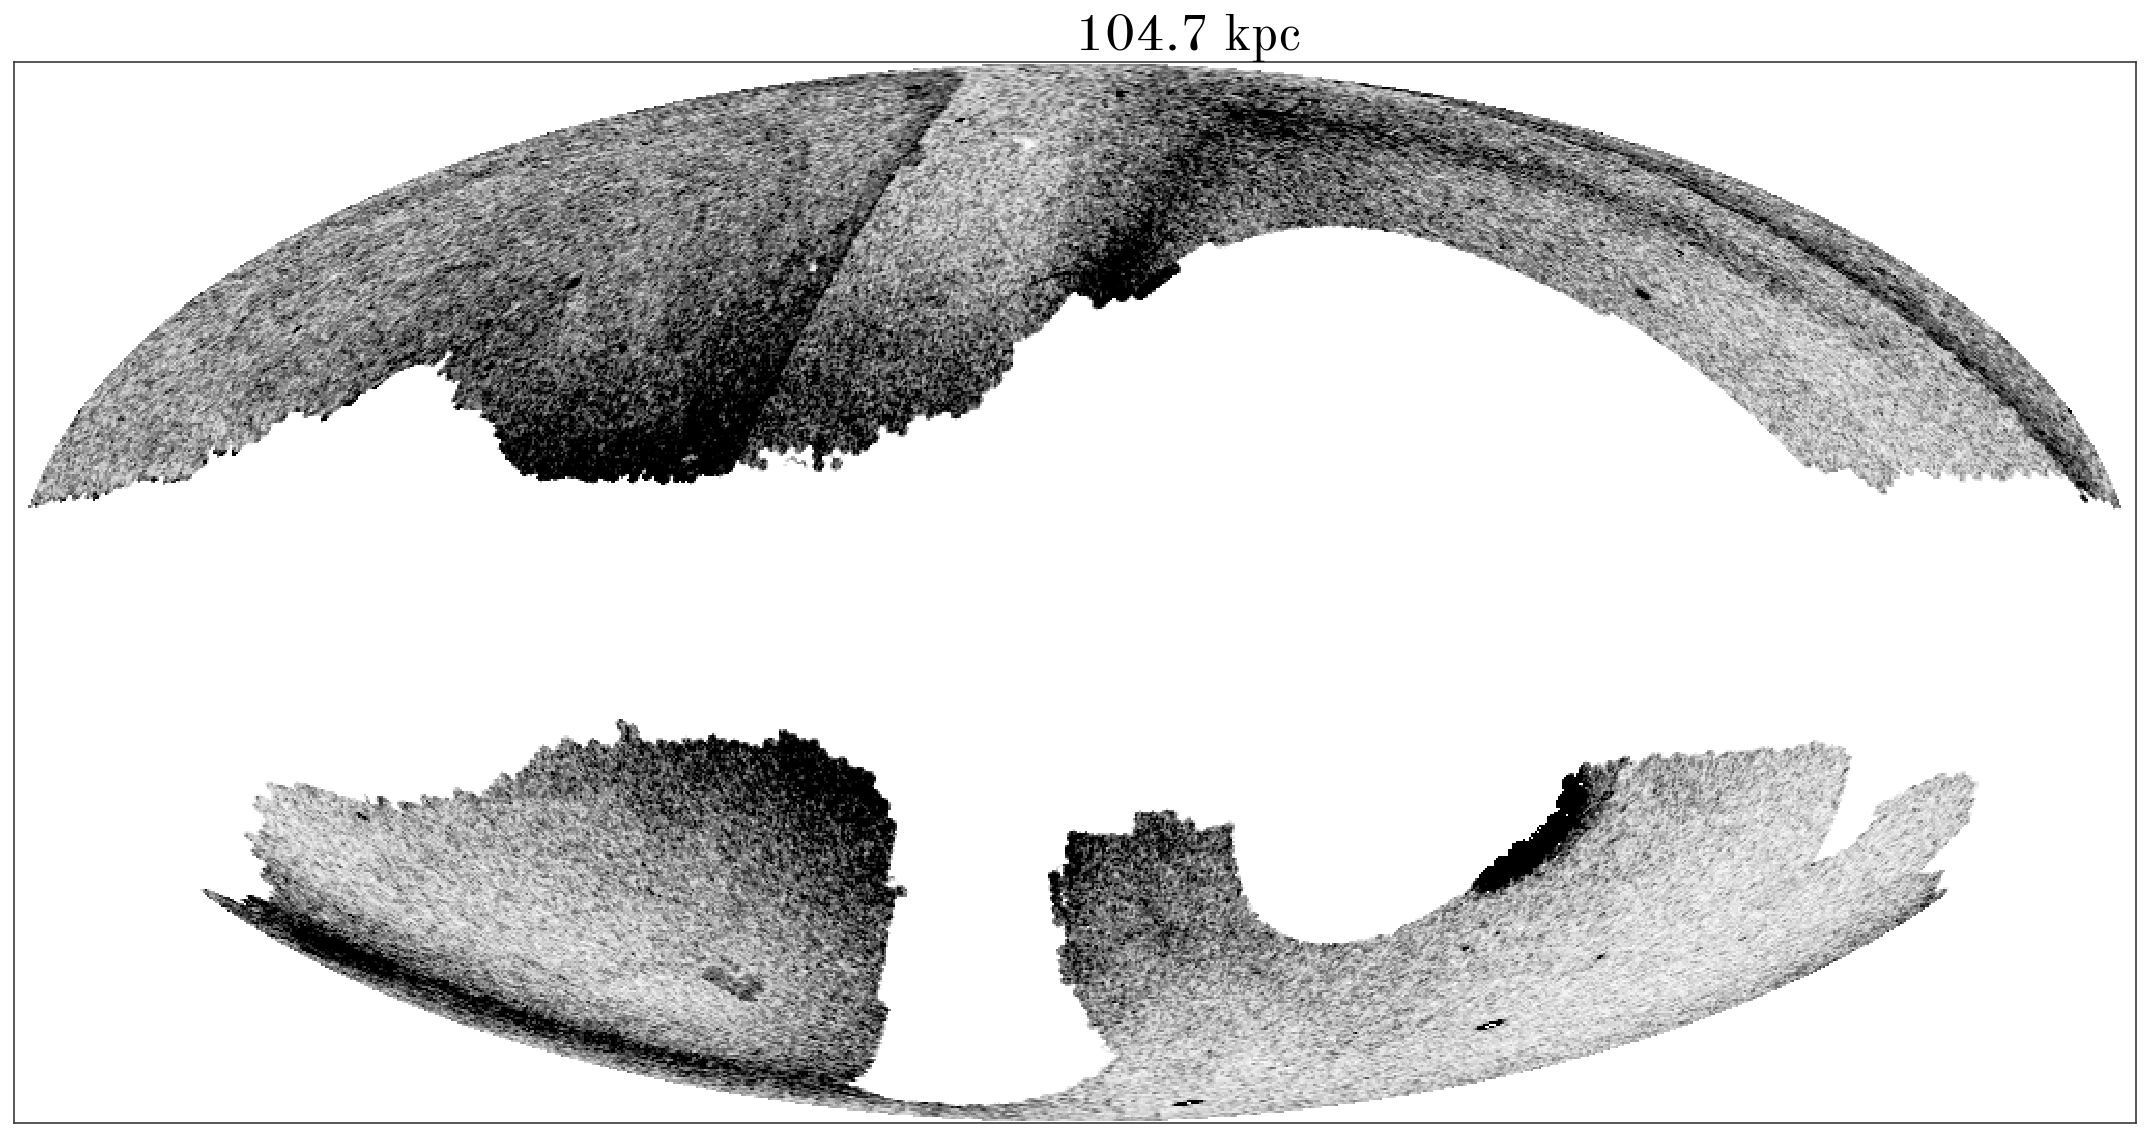

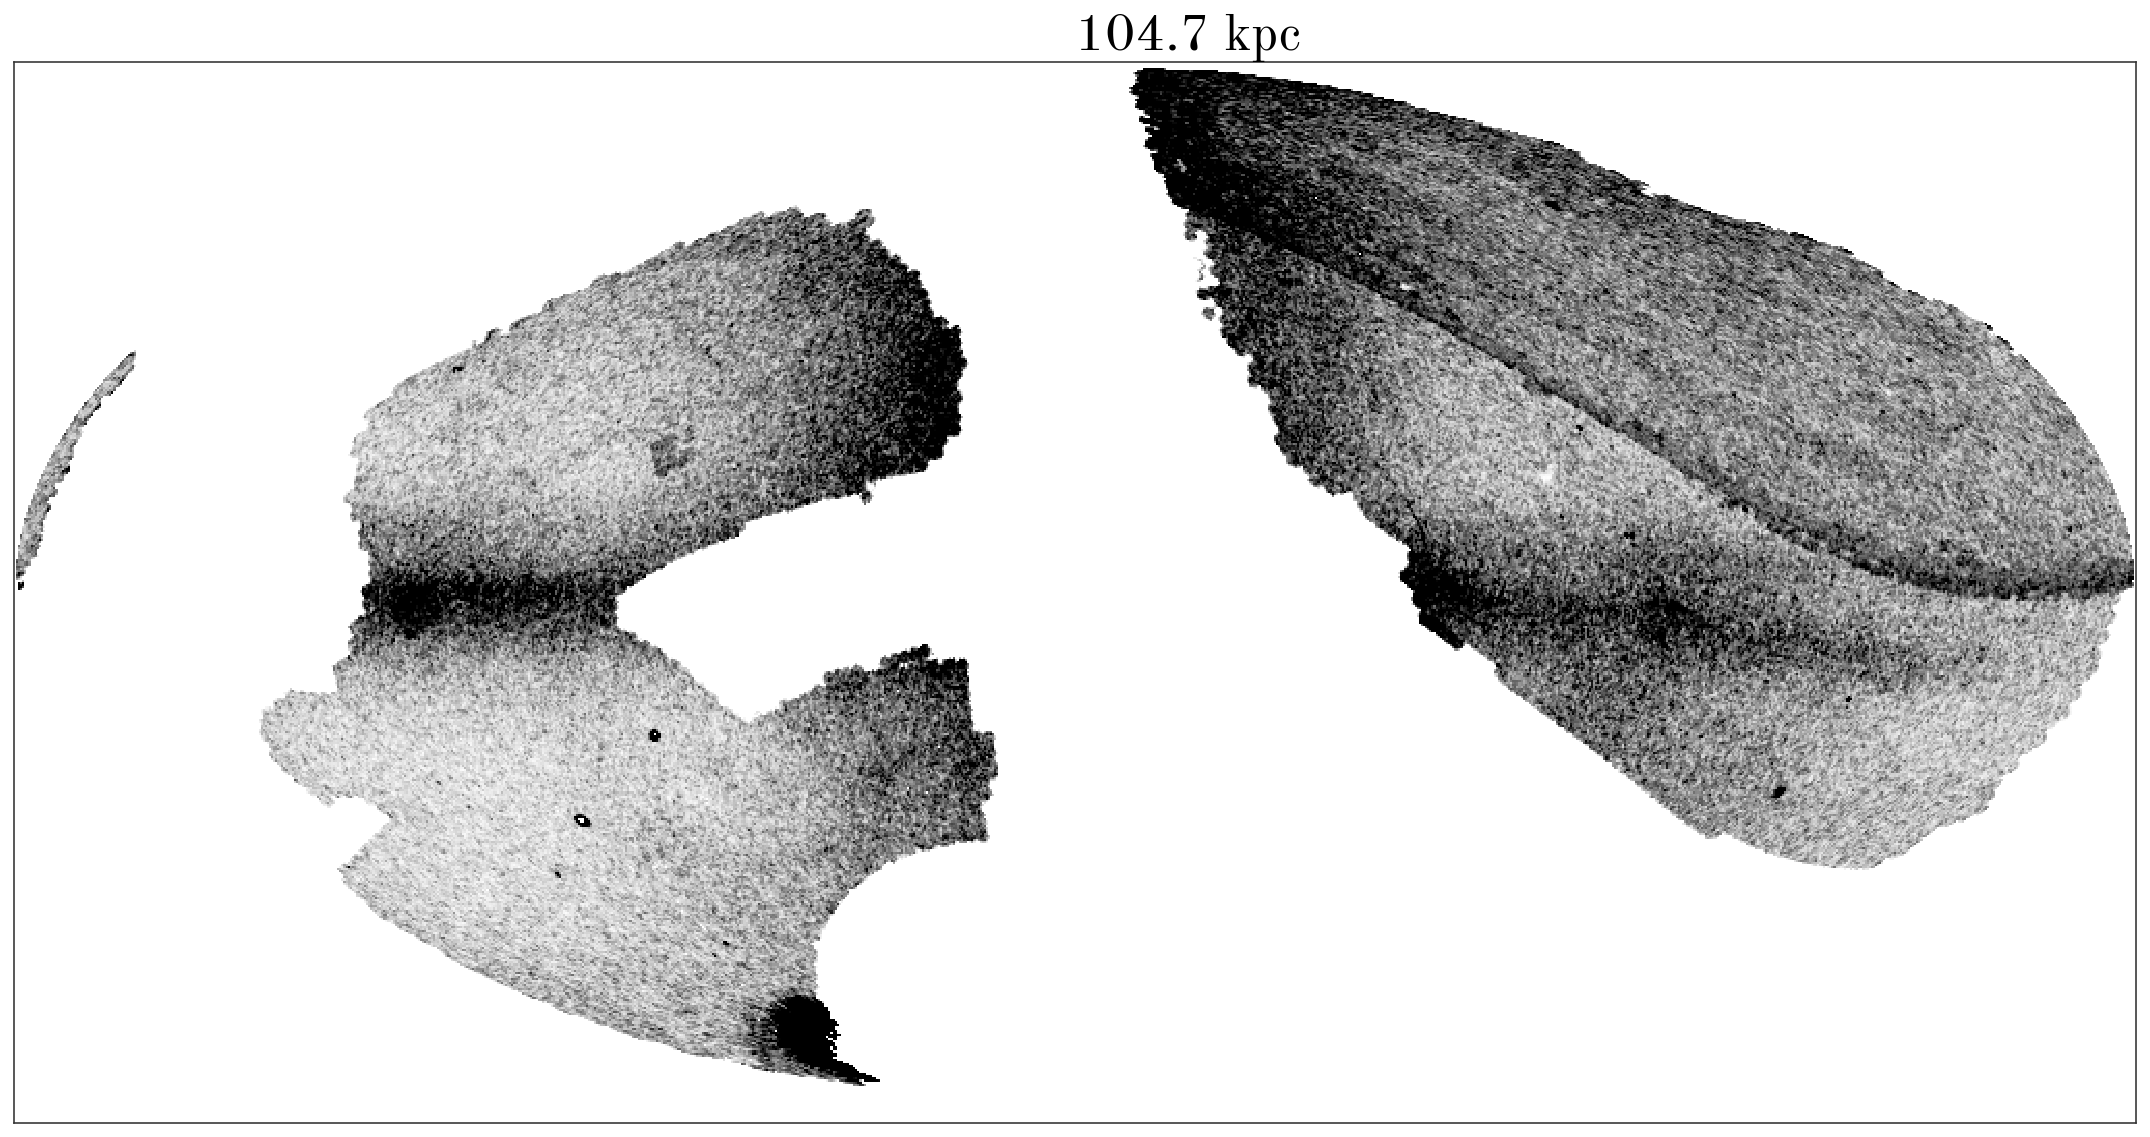

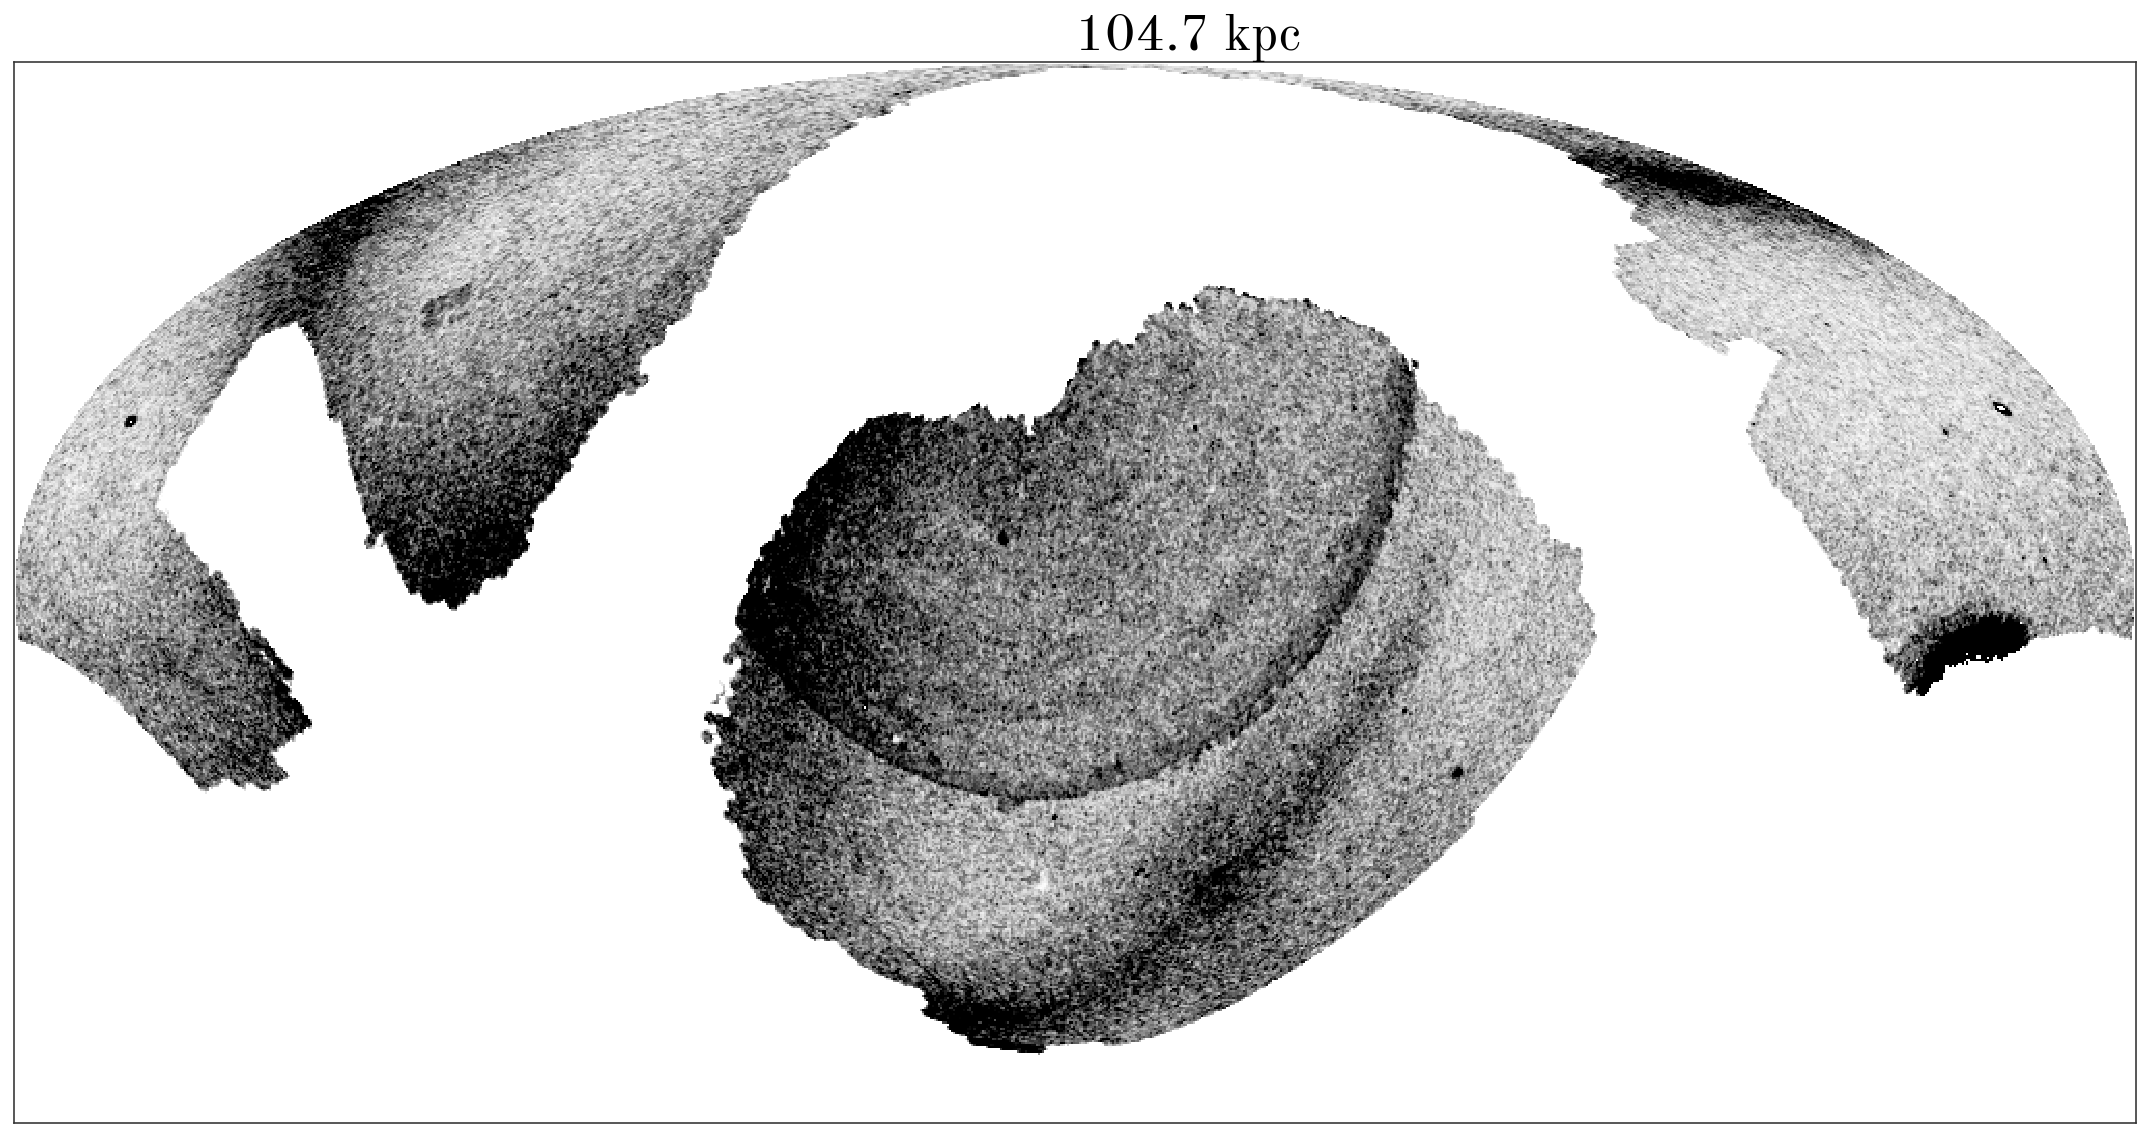

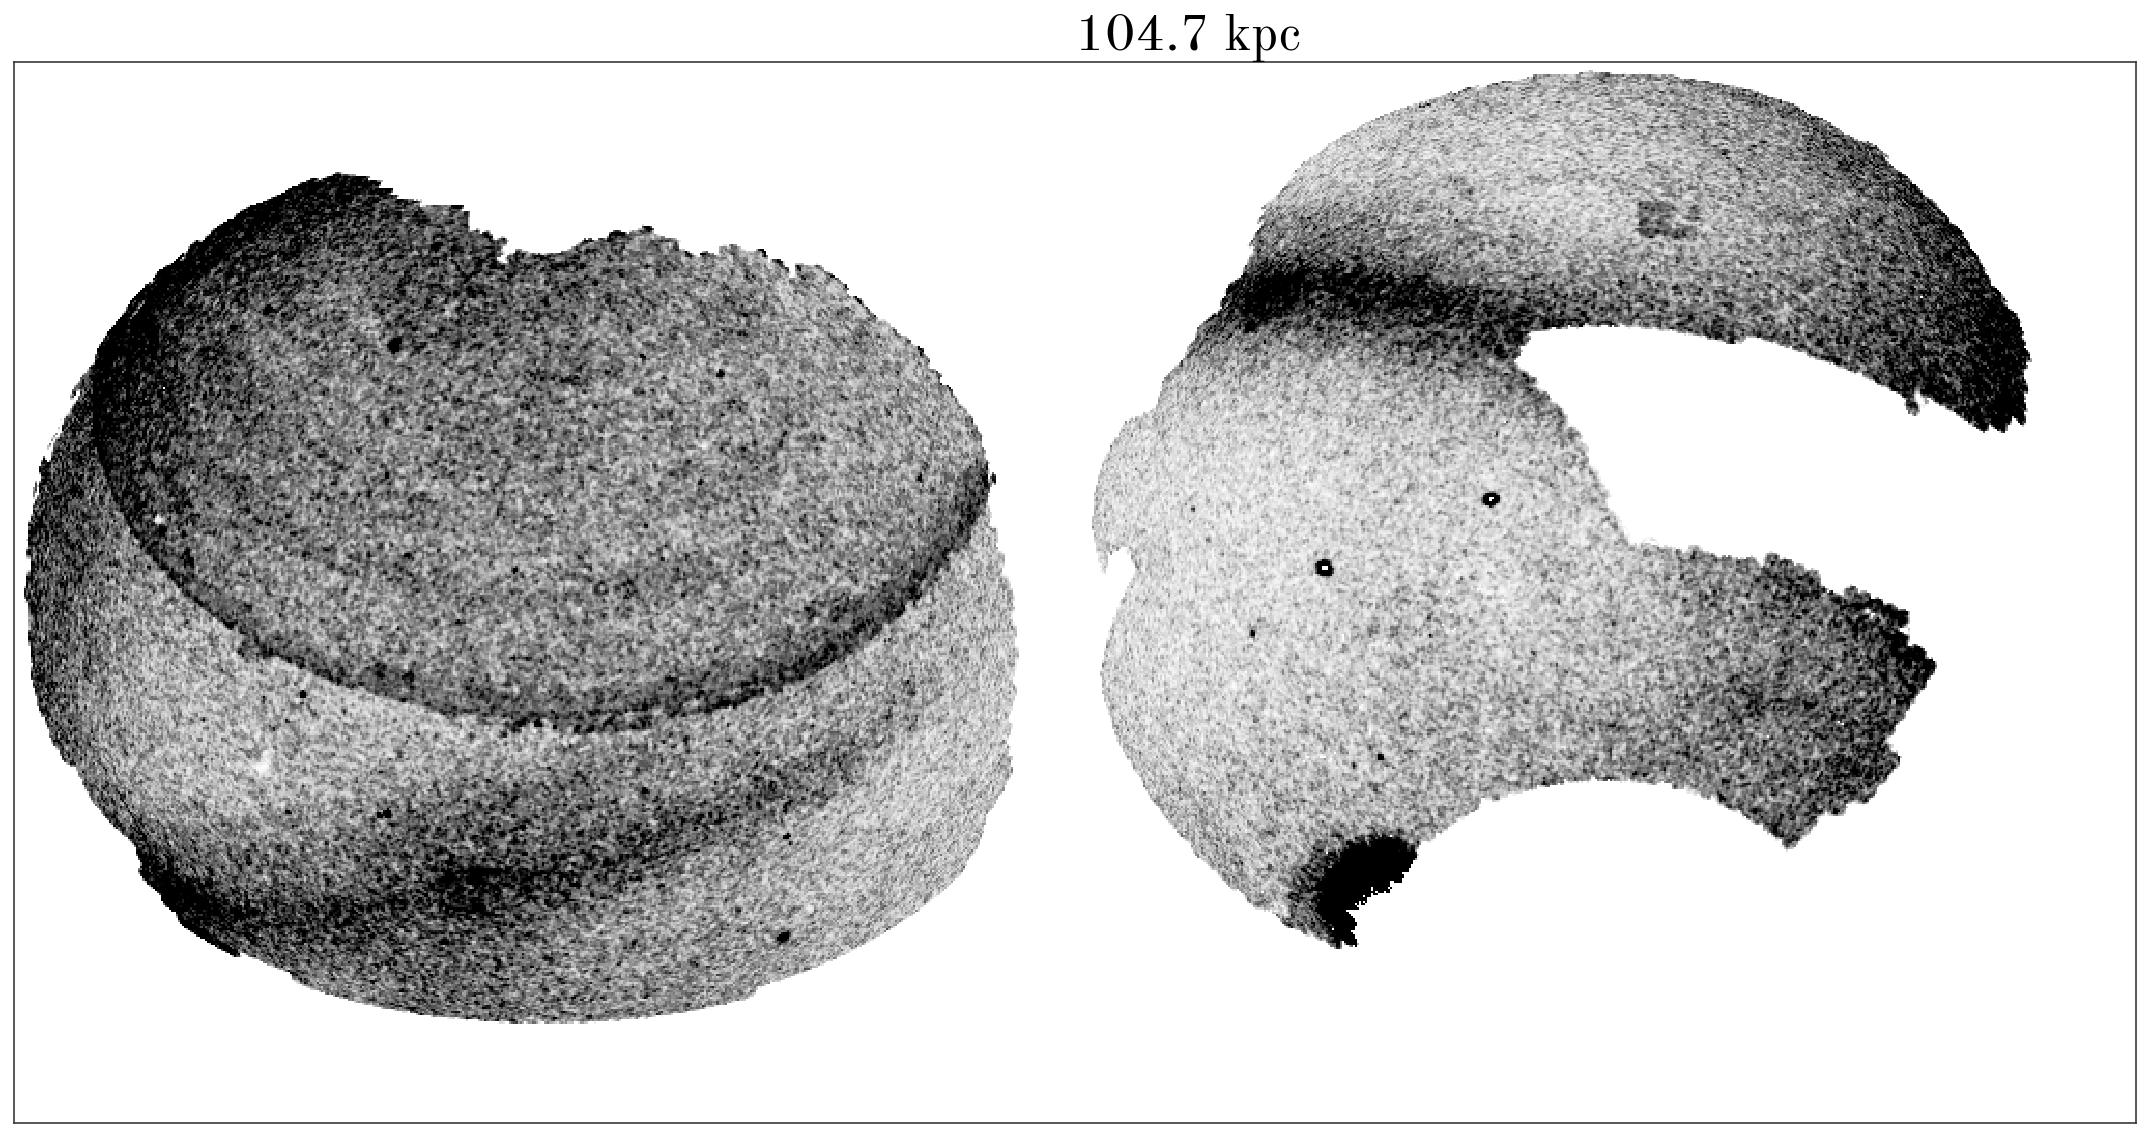

In [27]:
for name, proj in projs.items():
    # if name != 'icrs': continue
    
    # plot_path = os.path.join(f'../plots/gifs/{name}')
    # os.makedirs(plot_path, exist_ok=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title('d')
    fig.tight_layout()
    
    im = ax.imshow(proj.projmap(np.zeros(hp.nside2npix(nside)), func), 
                   cmap='Greys', origin='bottom', extent=proj.get_extent())
    
    def plot_slice(i):
        print(i)
        ax.set_title('{:.1f} kpc'.format(distances[i]), ha='left')
        
        X = hp.smoothing(cube[:, i], sigma=np.radians(0.15))
        X = apwnorm(X) 
        X[cubesum == 0] = 0.
        
        im.set_array(proj.projmap(X, func))
        
        tmp = X.copy()
        tmp[~pix_b_mask] = 0.
        vmin = np.percentile(tmp, 1),
        vmax = np.percentile(tmp, 99.2)
        im.norm.vmin = vmin
        im.norm.vmax = vmax
        return im,
    
    anim = FuncAnimation(fig, plot_slice, frames=nslice, 
                         blit=True)
    anim.save(f'../plots/fieldofstreams/gr/{name}.mp4', dpi=250)
    
    #for i in np.arange(n_slice, dtype=int):
        
        
#         fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#         im = ax.imshow(proj.projmap(X, func), cmap='Greys',
#                        origin='bottom', extent=proj.get_extent())
#         ax.xaxis.set_visible(False)
#         ax.yaxis.set_visible(False)
#         fig.tight_layout()

        # fig.savefig(os.path.join(plot_path, f'{i:02d}.png'), dpi=200)
#         break
    del anim

<ICRS Coordinate: (ra, dec) in deg
    (200., 59.4504341)>


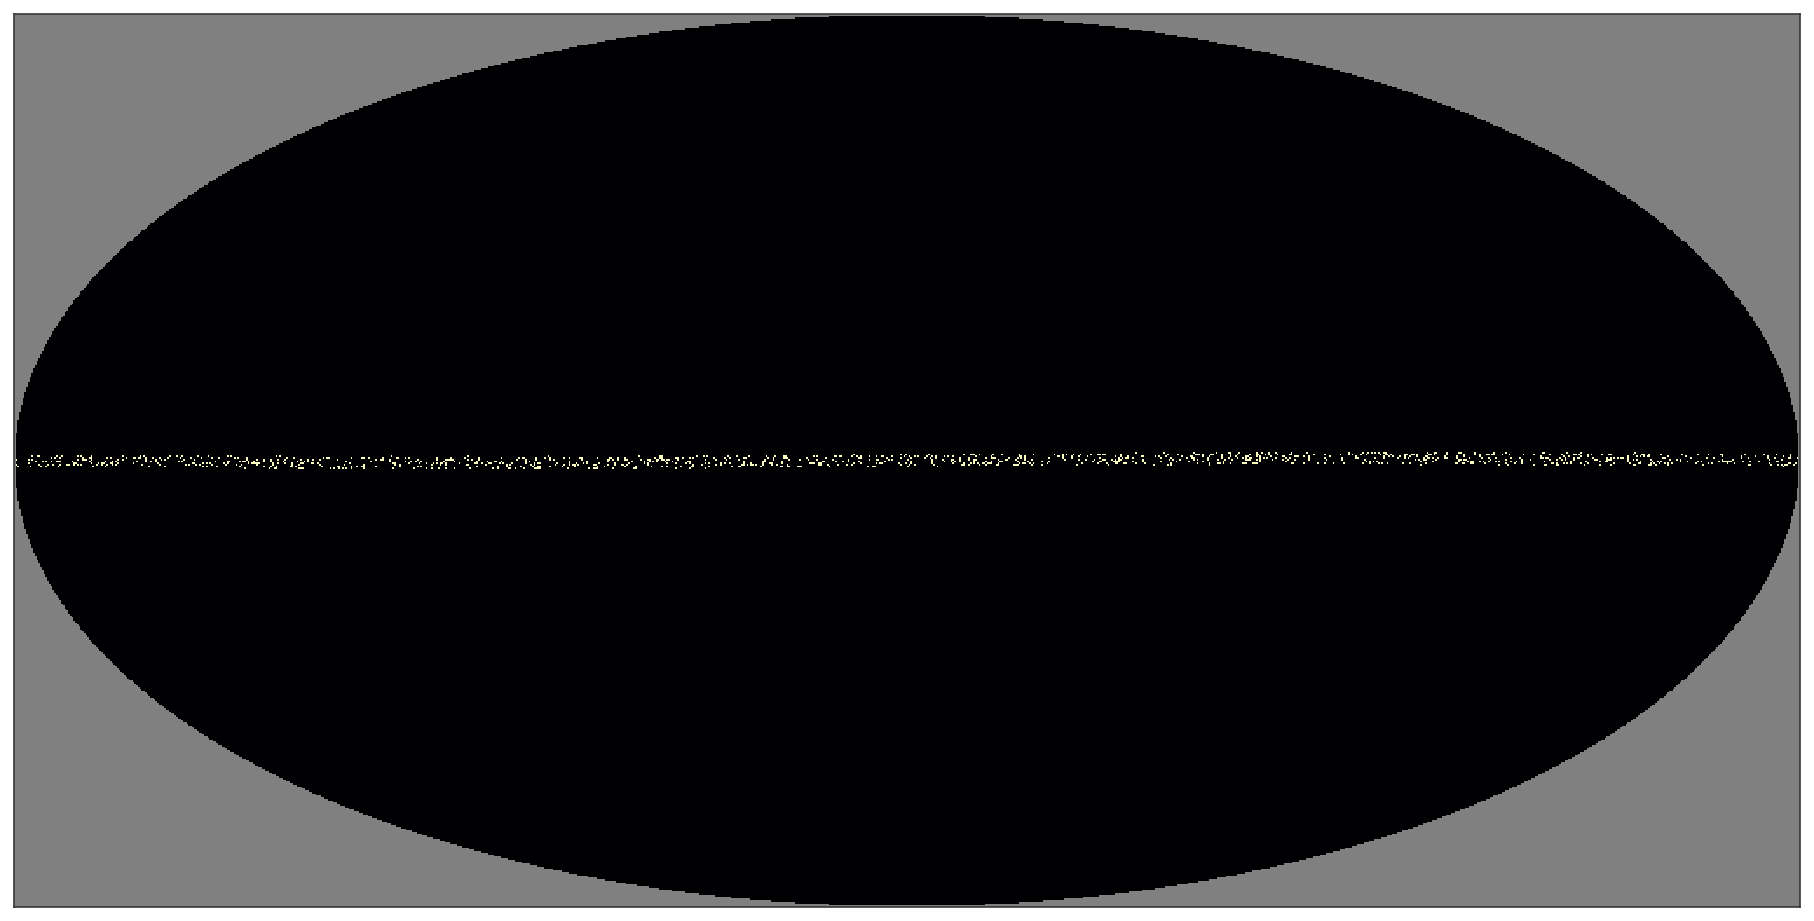

In [625]:
# print(coord.Galactic(0*u.deg, 0*u.deg).transform_to(coord.ICRS))


# gal = coord.Galactic(np.random.uniform(0, 360, 10000)*u.deg, 
#                      np.random.uniform(-1, 1, size=10000)*u.deg)
# icrs = gal.transform_to(coord.ICRS)

# hack = np.zeros_like(rgb[:, 0])
# hack[hp.ang2pix(nside, icrs.ra.degree, icrs.dec.degree, lonlat=True)] = 1.
# img = proj.projmap(hack, func) 

# Sag:
# print(gc.Sagittarius(0*u.deg, 0*u.deg).transform_to(coord.ICRS))


# gal = gc.Sagittarius(np.random.uniform(0, 360, 10000)*u.deg, 
#                      np.random.uniform(-1, 1, size=10000)*u.deg)
# icrs = gal.transform_to(coord.ICRS)

# hack = np.zeros_like(rgb[:, 0])
# hack[hp.ang2pix(nside, icrs.ra.degree, icrs.dec.degree, lonlat=True)] = 1.

# proj = hp.projector.MollweideProj(xsize=1024, 
#                                   rot=[284.03876751, -29.00408353, -10.])
# img = proj.projmap(hack, func) 

# GD-1:
# print(gc.GD1(0*u.deg, 0*u.deg).transform_to(coord.ICRS))

# gal = gc.GD1(np.random.uniform(0, 360, 10000)*u.deg, 
#                      np.random.uniform(-1, 1, size=10000)*u.deg)
# icrs = gal.transform_to(coord.ICRS)

# hack = np.zeros_like(rgb[:, 0])
# hack[hp.ang2pix(nside, icrs.ra.degree, icrs.dec.degree, lonlat=True)] = 1.

# proj = hp.projector.MollweideProj(xsize=1024, 
#                                   rot=[200., 59.4504341, 13.])
# img = proj.projmap(hack, func) 

# fig, ax = plt.subplots(1, 1, figsize=(16, 16))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)

---

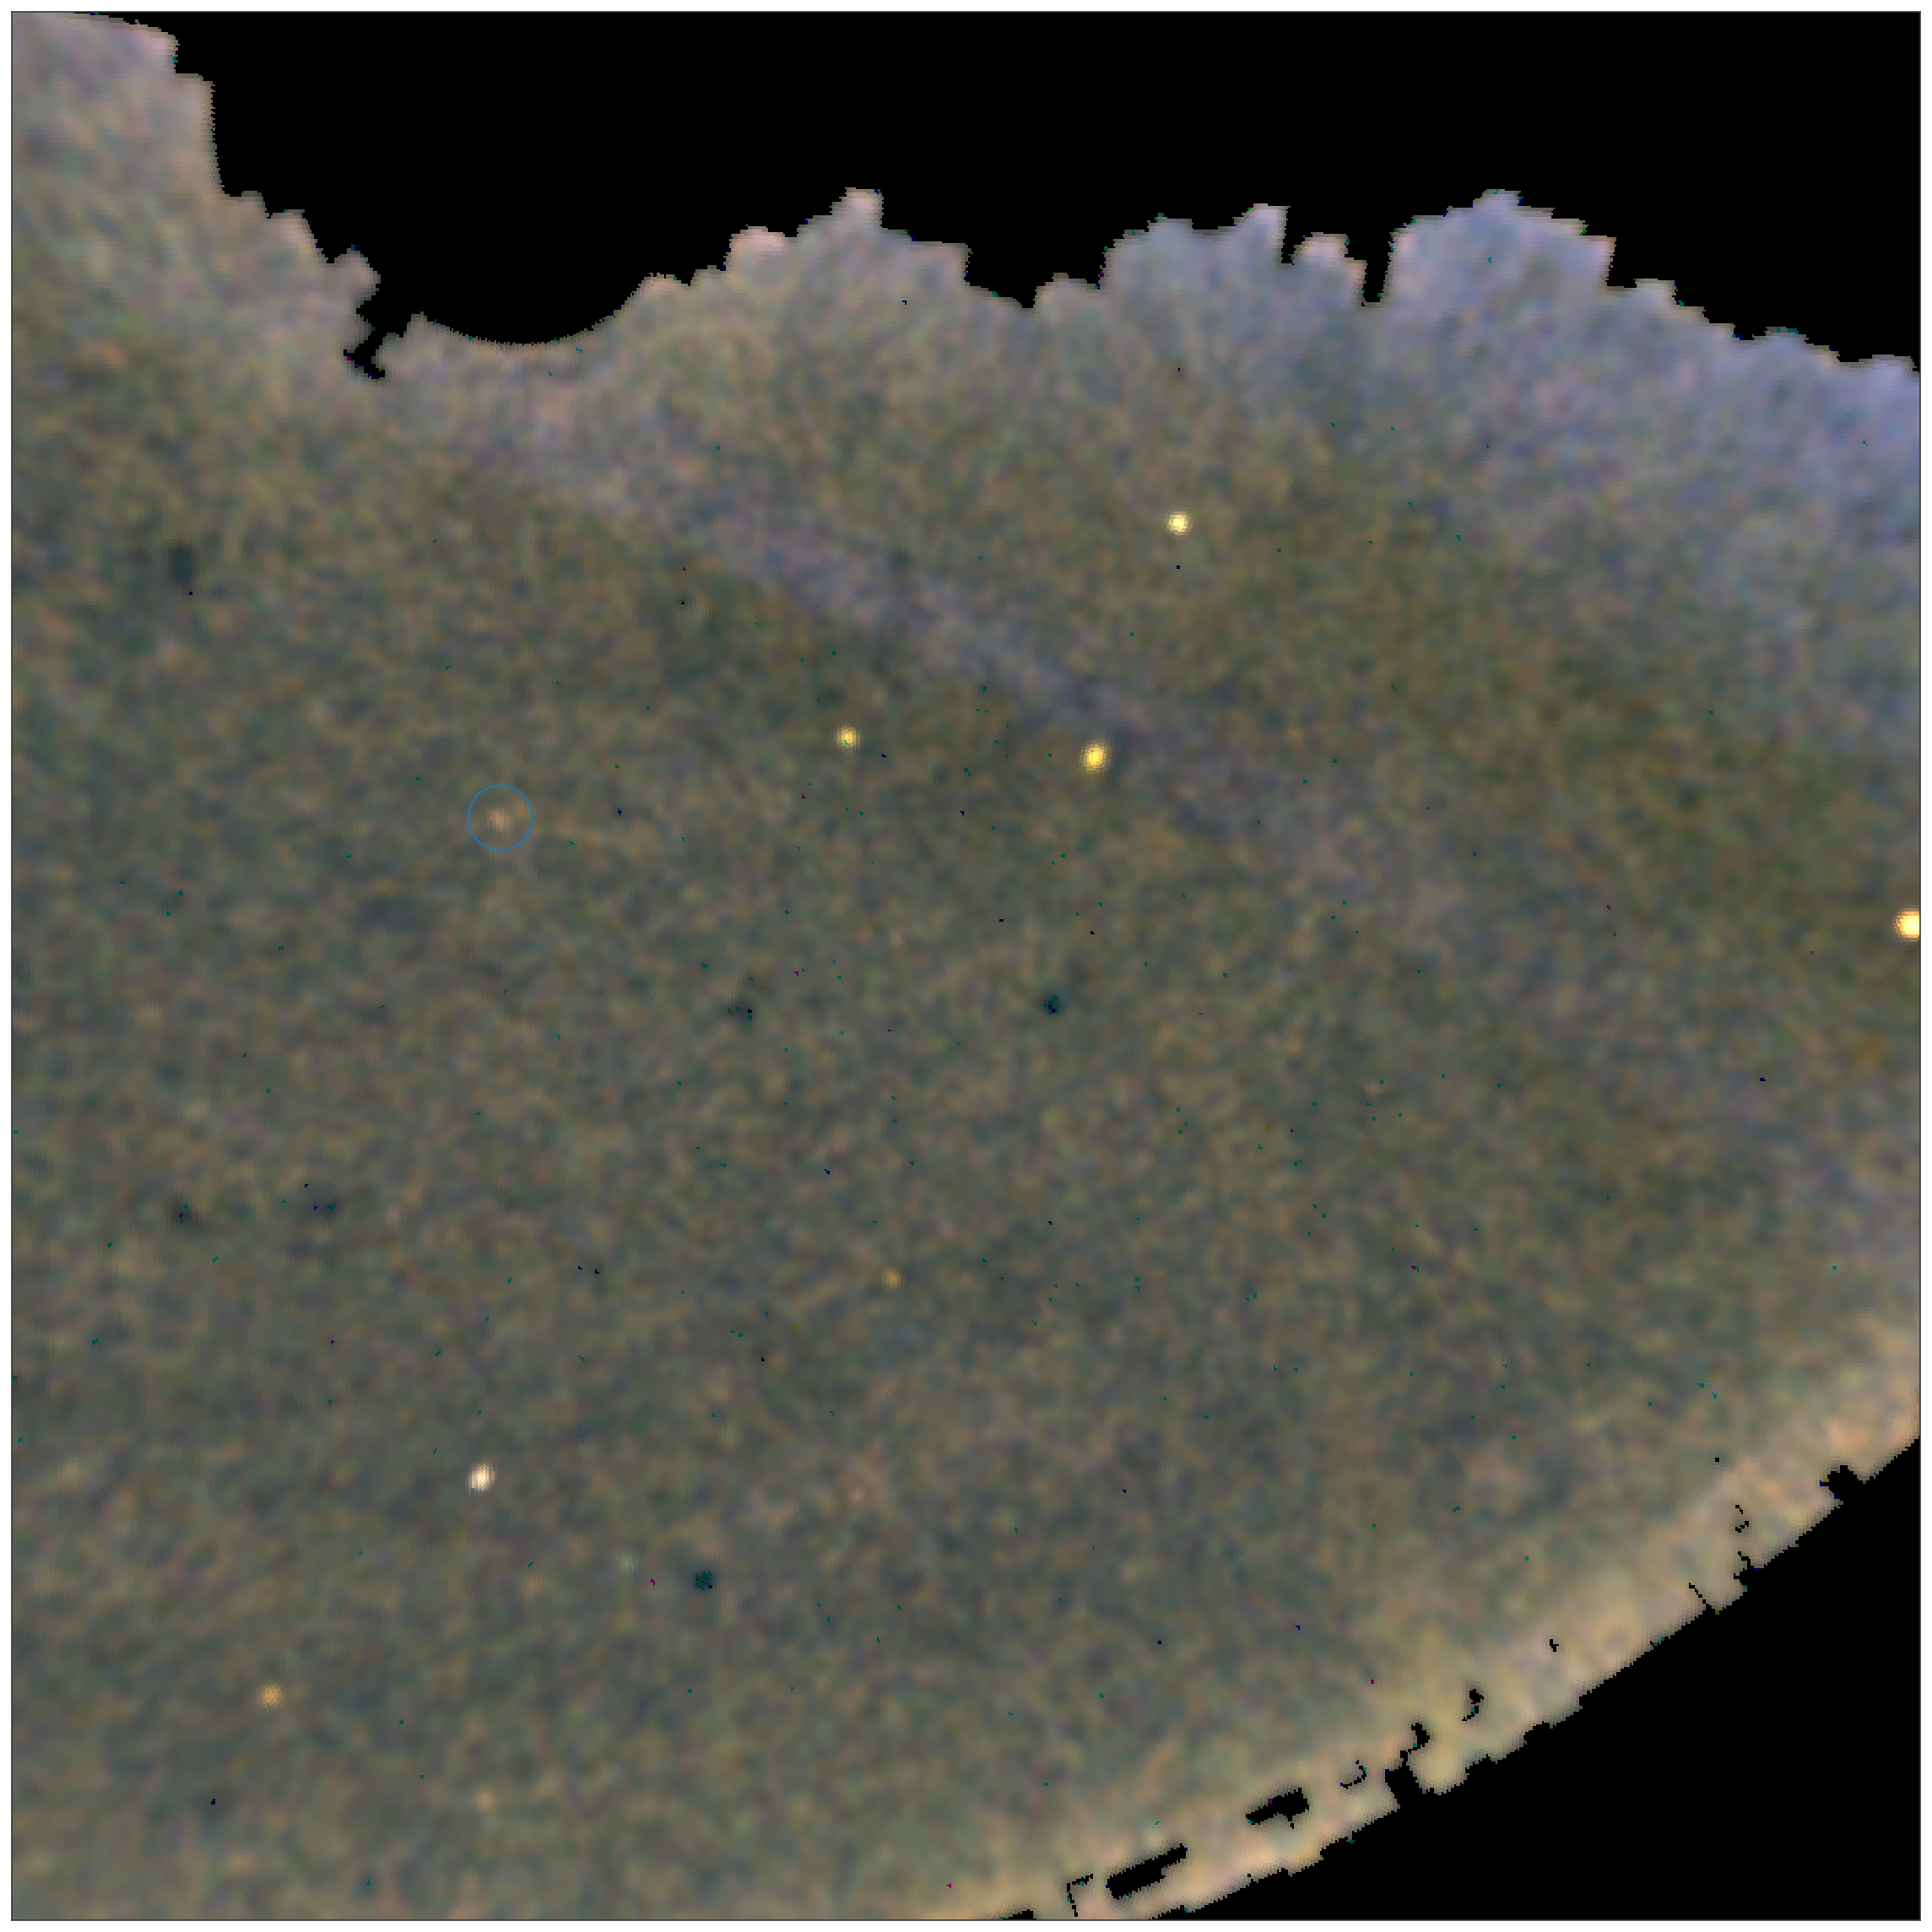

In [175]:
proj = hp.projector.GnomonicProj(xsize=1024, ysize=1024,
                                 rot=[150, 60, 30], reso=4)

img = np.stack([proj.projmap(rgb[:, i], func) 
                for i in range(3)], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

xy = proj.ang2xy(184, 69.4, lonlat=True)
ax.add_patch(mpl.patches.Circle(xy, radius=0.02,
                                facecolor='none', 
                                edgecolor='tab:blue', zorder=100, 
                                linewidth=1))

fig.tight_layout()